### Dane powiny być zorganizowane w folderze/lub w folderach w taki sposób żeby każdy sygnał był w fromcie .tdms a jego nazwa zawierała [nazwa unikalna dla folderu (liczba)] np d1sas0.tdms gdzie 'd1sas' to unikalna nazwa a '0' to numer pomiaru liczby powiny


Jeśli pliki są uporzadkowane w innej formie to pominąć wszyskie kroki do bloku z funkcją obliczającą stft.
Dostarczyć do tego bloku należy sygnały które zostały:
-przepuszczone przez filtr środkowo przepustowy o dolnym granicy 3000 a górnej 10000

-usuniecie przesuniecia skłądowej stałej sygnału (od każdej próbki należy odjąć wartość średnią sygnału)

-dane dla każdych trzech pomiarówch pochodzących z konretnej kotwy powiny zostać skrócone do wartości długośći najkrzutrszego sygnału np mamy len(signal1) => 10000 len(siganl2) => 15000 len(signal3) => 7500 to wszyskie sygnały należy wyrównać do 7500

-po wyrównaniu dzielimy sygnały na 50 000 próbk i kazdy z takich fragmentów łączymy w pakiety po 3 syganły odpowaidajace 3 sygnałom pomiarowym z kotew. np z 3 sygnałów pochodzącej z jednej kotwy gdzie kazdy po skróceniu ma 200 000 pkt otrzymujemy 4 pakiety o krztałcie [3, 50 000]

Takie pakiety upchnięte w pd.dataframe przepuszaczmy przez funkjcje obliczajacą stft


In [1]:
# Standard library imports
import os
import re
import warnings
from pathlib import Path

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.signal import butter, lfilter, freqz, stft
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from transformers import (
    ViTImageProcessor, 
    ViTForImageClassification, 
    ViTConfig, 
    AdamW, 
    get_scheduler
)
from tqdm.auto import tqdm
import joblib

# Special-purpose imports
from nptdms import TdmsFile

# Suppress warnings
warnings.filterwarnings('ignore')

c:\Users\patry\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Opis kodu

Kod przeszukuje katalog oraz jego podkatalogi w celu znalezienia plików `.tdms` i zapisania ich pełnych ścieżek na liście.

1. **Zmienna `tdms_dir`**: Określa ścieżkę do katalogu, w którym znajdują się pliki `.tdms`.
2. **Przeszukiwanie katalogu**: Funkcja `os.walk()` iteruje przez katalogi i pliki w zadanej lokalizacji.
3. **Filtracja plików**: Dla każdego pliku sprawdzane jest, czy kończy się na `.tdms`. Jeśli tak, jego pełna ścieżka jest dodawana do listy `tdms_list`.
4. **Wyświetlanie informacji**: Dla każdego katalogu wyświetlana jest liczba podkatalogów i plików.

W rezultacie `tdms_list` zawiera ścieżki wszystkich plików `.tdms`.


In [2]:
tdms_dir = r'C:\Users\patry\Desktop\studia\engineering_thesis\kopalnia' 

tdms_list = []

for root, dirs, files in os.walk(tdms_dir):
    print(f"There are {len(dirs)} directories and {len(files)} file in {root}")
    
    for file in files:
        if file.endswith(".tdms"):
            tdms_list.append(os.path.join(root, file))

There are 3 directories and 0 file in C:\Users\patry\Desktop\studia\engineering_thesis\kopalnia
There are 0 directories and 112 file in C:\Users\patry\Desktop\studia\engineering_thesis\kopalnia\020224wieliczka
There are 0 directories and 76 file in C:\Users\patry\Desktop\studia\engineering_thesis\kopalnia\210224wieliczka
There are 0 directories and 86 file in C:\Users\patry\Desktop\studia\engineering_thesis\kopalnia\220424wieliczka


### Opis kodu

Kod przetwarza pliki `.tdms` z wcześniej utworzonej listy `tdms_list`, wyodrębniając dane i zapisując je w obiekcie DataFrame.

1. **Tworzenie listy `data_list`**: Inicjalizowana jest pusta lista, która będzie przechowywać dane z plików.
   
2. **Przetwarzanie plików `.tdms`**:
   - Dla każdego pliku TDMS z listy `tdms_list`:
     - Otwierany jest plik przy użyciu `TdmsFile.read()`.
     - Z nazwy pliku wyciągana jest jego nazwa oraz nazwa folderu nadrzędnego.
     - Za pomocą wyrażeń regularnych wyciągane są identyfikatory, takie jak numer na początku nazwy pliku oraz numer przed ostatnim folderem.
   
3. **Dodawanie danych do listy**:
   - Sprawdzane są warunki: jeśli nazwa pliku nie zaczyna się od 'z' i jeśli kanał ma nazwę 'Voltage', to dane z kanału są dodawane do listy `data_list` w postaci słownika zawierającego:
     - `excitation` – dane z kanału,
     - `type_id` – wartość 1, jeśli nazwa pliku zaczyna się od 'd', w przeciwnym razie 0,
     - `identifier` – wyekstrahowany identyfikator z nazwy pliku i folderu nadrzędnego.

4. **Tworzenie DataFrame**:
   - Na podstawie listy `data_list` tworzony jest obiekt `DataFrame` o nazwie `df_magnitude`, który zawiera wszystkie przetworzone dane.


In [3]:
data_list = []

for tdms_file_path in tdms_list:
    tdms_file = TdmsFile.read(tdms_file_path)
    file_name = os.path.basename(tdms_file_path) 
    parent_folder = os.path.basename(os.path.dirname(tdms_file_path)) 

    first_letter_number = re.match(r'^[a-zA-Z]+\d+', file_name) 
    identifier = first_letter_number.group() if first_letter_number else None 

    # Wyciągnij numer przed ostatnim folderem (np. "020224" z "020224wieliczka")
    match_parent_number = re.match(r'\d+', parent_folder)
    parent_number = match_parent_number.group() if match_parent_number else ""

    if identifier and parent_number:
        identifier = f"{parent_number}{identifier}"

    for group in tdms_file.groups():
        for channel in group.channels():
            data_len = np.shape(channel.data)[0]
            if (file_name[0] != 'z' and channel.name == 'Voltage'):
                data_list.append({
                    'excitation': channel.data,
                    'type_id': 1 if file_name[0] == 'd' else 0,
                    'identifier': identifier  
                })

df_magnitude = pd.DataFrame(data_list)

### Opis kodu

Kod wykonuje filtrowanie pasmowe danych zawartych w kolumnie `excitation` DataFrame `df_magnitude` za pomocą funkcji `bandpass_filter`.

1. **Funkcja `bandpass_filter`**:
   - **Wejście**:
     - `data` – dane wejściowe, które mają zostać przefiltrowane,
     - `lowcut` – dolna granica pasma (częstotliwość),
     - `highcut` – górna granica pasma (częstotliwość),
     - `fs` – częstotliwość próbkowania,
     - `order` – rząd filtra (domyślnie 5).
   - **Działanie**:
     - Częstotliwość Nyquista (`nyquist`) jest obliczana jako połowa częstotliwości próbkowania.
     - Częstotliwości graniczne (`low` i `high`) są przekształcane do jednostki Nyquista.
     - Projektowany jest filtr pasmowy przy użyciu funkcji `butter` z biblioteki `scipy.signal`, a następnie sygnał jest filtrowany za pomocą funkcji `lfilter`.
   - **Wyjście**:
     - Przefiltrowane dane (sygnał) są zwracane.

2. **Filtrowanie danych**:
   - Wartości w kolumnie `excitation` DataFrame `df_magnitude` są przetwarzane, aby dla każdej z nich zastosować filtr pasmowy.
   - Zakłada się pasmo 4000-8000 Hz i częstotliwość próbkowania 50000 Hz, co jest realizowane za pomocą metody `.apply()`, która stosuje funkcję `bandpass_filter` do każdej próbki danych w kolumnie.


In [4]:
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs  # Częstotliwość Nyquista
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Projektowanie filtra
    b, a = butter(order, [low, high], btype='band')
    # Filtrowanie sygnału
    y = lfilter(b, a, data)
    return y

df_magnitude['excitation'] = df_magnitude['excitation'].apply(lambda x: bandpass_filter(x, 4000, 8000, 50000))

### Opis kodu

Ten fragment kodu przetwarza dane w DataFrame `df_magnitude` poprzez tworzenie unikalnych identyfikatorów dla wartości w kolumnie `identifier` oraz filtrowanie wierszy zduplikowanych identyfikatorów.

1. **Tworzenie kolumny `id`**:
   - Funkcja `pd.factorize()` jest używana do przypisania unikalnych liczb całkowitych do różnych wartości w kolumnie `identifier`. Wynikiem tej funkcji jest krotka, w której pierwszy element to tablica z przypisanymi liczbami całkowitymi, a drugi to lista unikalnych wartości.
   - Przypisujemy tylko pierwszą część krotki (unikalne liczby) do nowej kolumny `id` w DataFrame `df_magnitude`.

2. **Filtrowanie wierszy zduplikowanych identyfikatorów**:
   - Funkcja `.duplicated()` sprawdza, które wiersze mają zduplikowane identyfikatory w kolumnie `id`. Argument `keep=False` oznacza, że wszystkie wystąpienia zduplikowanych identyfikatorów (a nie tylko pierwsze) będą oznaczone jako `True`.
   - Tylko wiersze, które mają zduplikowane identyfikatory, są zachowywane w DataFrame, ponieważ filtrujemy DataFrame, pozostawiając tylko te wiersze, w których `id` jest zduplikowane (usuwane sa pojedyncze wartosci identyfikatorów)

3. **Rezultat**:
   - DataFrame `df_magnitude` zawiera teraz tylko te wiersze, które mają zduplikowane wartości w kolumnie `identifier`, a nowa kolumna `id` zawiera przypisane numery identyfikacyjne dla każdego unikalnego identyfikatora.


In [5]:
df_magnitude['id'] = pd.factorize(df_magnitude['identifier'])[0]
df_magnitude = df_magnitude[df_magnitude['id'].duplicated(keep=False) == True]
df_magnitude

,excitation,type_id,identifier,id
0,"[0.005053682283559274, 0.03691918726452065, 0....",1,020224d10,0
1,"[-0.005080443155479619, -0.03630902828002723, ...",1,020224d10,0
2,"[0.005053682283559274, 0.03691918726452065, 0....",1,020224d10,0
3,"[0.005053682283559274, 0.026785061825481758, 0...",1,020224d10,0
4,"[-1.3198560286974615e-05, -8.192032366132593e-...",1,020224d1,1
...,...,...,...,...
124,"[-0.005104894796977349, -0.03729331532938133, ...",0,220424g3,48
125,"[0.0051132676500922165, 0.03735448239821186, 0...",0,220424g3,48
126,"[0.0051132676500922165, 0.03735448239821186, 0...",0,220424g6,49
127,"[-0.005104894796977349, -0.03729331532938133, ...",0,220424g6,49


### Opis kodu

Ten fragment kodu grupuje dane w DataFrame `df_magnitude` według kolumny `id` i przetwarza grupy w celu podziału ich na dwie podgrupy, jeżeli grupa ma dokładnie 6 elementów.

1. **Grupowanie danych**:
   - Dane są grupowane według kolumny `id` za pomocą funkcji `groupby()`. Tworzy to obiekt, który umożliwia iterację przez każdą grupę danych.

2. **Przetwarzanie każdej grupy**:
   - Dla każdej grupy (czyli dla każdego unikalnego `id`):
     - **Sprawdzenie długości grupy**: Jeżeli grupa ma dokładnie 6 elementów, to:
       - Grupa jest dzielona na dwie podgrupy (pierwsza połowa i druga połowa).
       - Wartość identyfikatora w drugiej podgrupie jest zwiększana o 100 (modyfikacja kolumny `id`).
       - Obie podgrupy są dodawane do listy `new_rows`.
     - Jeśli grupa ma inną długość niż 6, jest dodawana do listy `new_rows` bez zmian.

3. **Tworzenie nowego DataFrame**:
   - Wszystkie przetworzone grupy (zarówno zmodyfikowane, jak i niezmienione) są łączone w jeden DataFrame za pomocą funkcji `pd.concat()`, a wynikowy DataFrame jest przypisany z powrotem do `df_magnitude`.

4. **Rezultat**:
   - `df_magnitude` zawiera teraz dane, w których grupy o identyfikatorach z grupą 6 elementów zostały podzielone na dwie podgrupy, z modyfikacją identyfikatora w drugiej podgrupie.


In [6]:
grouped = df_magnitude.groupby('id')

new_rows = []

for group_id, group in grouped:
    if len(group) == 6:
        half = len(group) // 2
        group1 = group.iloc[:half]
        group2 = group.iloc[half:]
        
        group2['id'] = group_id + 100
        
        new_rows.append(group1)
        new_rows.append(group2)
    else:
        new_rows.append(group)

# Łączymy wszystkie wiersze w jeden DataFrame
df_magnitude = pd.concat(new_rows, ignore_index=True)

### Opis kodu

Ten fragment kodu przetwarza dane w DataFrame `df_magnitude`, dodając lub usuwając wiersze na podstawie liczby wystąpień identyfikatora `id` w zbiorze danych.

1. **Obliczanie liczby wystąpień identyfikatora `id`**:
   - Funkcja `groupby('id').size()` oblicza liczbę wystąpień każdego unikalnego identyfikatora `id` w DataFrame `df_magnitude`. Wynik jest zapisywany w zmiennej `counts`, która zawiera identyfikatory oraz ich liczbę wystąpień.

2. **Tworzenie kopii DataFrame**:
   - Tworzona jest kopia DataFrame `df_magnitude` pod nazwą `modified_df`, aby wprowadzać zmiany na kopii, zachowując oryginalne dane.

3. **Przetwarzanie wierszy na podstawie liczby wystąpień identyfikatora `id`**:
   - **Dla identyfikatorów występujących 2 razy**: Wiersz z identyfikatorem występującym dwukrotnie zostaje skopiowany i dodany do `modified_df` (dodanie duplikatu).
   - **Dla identyfikatorów występujących 4 razy**: Jeden z wierszy z identyfikatorem występującym czterokrotnie jest usuwany z `modified_df`.

4. **Sprawdzanie unikalnych identyfikatorów po modyfikacji**:
   - Funkcja `np.unique()` z argumentem `return_counts=True` zwraca unikalne identyfikatory `id` oraz liczbę ich wystąpień w zmodyfikowanym DataFrame `modified_df`. To pozwala sprawdzić, czy operacje dodawania i usuwania wierszy zostały przeprowadzone prawidłowo.

5. **Rezultat**:
   - W wyniku działania kodu identyfikatory, które występowały 2 razy, zostaną powielone, a te, które występowały 4 razy, zostaną zredukowane o jeden wiersz. Na końcu wyświetlane są unikalne identyfikatory oraz liczba ich wystąpień w zmodyfikowanym DataFrame.




Po tym procesie dane powiny byc już uporzadkowane po 3 moiary dla kazdej kotwy i print powinein wygalądać tak

 array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int64)


In [7]:
counts = df_magnitude.groupby('id').size()

modified_df = df_magnitude.copy()

for id_value, count in counts.items():
    if count == 2:
        rows_to_add = df_magnitude[df_magnitude['id'] == id_value].iloc[0:1]
        modified_df = pd.concat([modified_df, rows_to_add], ignore_index=True)
    elif count == 4:
        rows_to_remove = df_magnitude[df_magnitude['id'] == id_value].iloc[0:1]
        modified_df = modified_df[~modified_df.index.isin(rows_to_remove.index)]

np.unique(np.array(modified_df['id']), return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  11,  12,  20,
         21,  22,  24,  25,  26,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49, 111, 140,
        147], dtype=int64),
 array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int64))

### Opis kodu

Ten fragment kodu przetwarza dane w DataFrame `modified_df`, obliczając długości sygnałów, dostosowując długość sygnałów w ramach grup oraz obliczając czas trwania dla każdego sygnału.

1. **Dodanie kolumny 'len'**:
   - Kolumna `len` jest tworzona, w której dla każdej wartości w kolumnie `excitation` (zakładając, że `excitation` to lista lub tablica) obliczana jest jej długość za pomocą funkcji `len()`.

2. **Funkcja `trim_to_min_length`**:
   - Definiowana jest funkcja `trim_to_min_length()`, która:
     - Określa minimalną długość sygnału w grupie za pomocą `group['len'].min()`.
     - Dostosowuje wszystkie sygnały w grupie, przycinając je do tej minimalnej długości, co oznacza, że sygnały w obrębie jednej grupy będą miały tę samą długość.

3. **Zastosowanie funkcji w grupach**:
   - Na DataFrame `modified_df` wykonywane jest grupowanie po kolumnie `id` (dzięki `.groupby('id')`), a następnie do każdej grupy stosowana jest funkcja `trim_to_min_length`, co powoduje przycięcie sygnałów do minimalnej długości w grupie.

4. **Ponowne obliczenie długości sygnałów**:
   - Po przycięciu sygnałów, obliczana jest na nowo długość każdego sygnału i zapisywana w kolumnie `len`.

5. **Usuwanie poziomu indeksu**:
   - Funkcja `.droplevel(level=0)` usuwa poziom indeksu, który został dodany podczas grupowania.

6. **Usuwanie kolumny 'len'**:
   - Kolumna `len` jest usuwana za pomocą metody `.drop(columns=['len'])`, ponieważ jej rola została już spełniona.

7. **Obliczanie czasu trwania sygnału**:
   - Kolumna `time` jest tworzona, obliczając czas trwania sygnału jako długość sygnału podzieloną przez częstotliwość próbkowania (50000 próbek na sekundę). Czas trwania jest obliczany dla każdego sygnału i zapisany w kolumnie `time`.

8. **Rezultat**:
   - DataFrame `modified_df` zawiera teraz kolumny `excitation` (z przyciętymi sygnałami), `time` (z czasem trwania każdego sygnału) oraz pozostałe kolumny, a kolumna `len` została usunięta.


In [8]:
modified_df['len'] = modified_df['excitation'].apply(lambda x: len(x))

def trim_to_min_length(group):
    min_len = group['len'].min()  
    group['excitation'] = group['excitation'].apply(lambda x: x[:min_len]) 
    return group

modified_df = modified_df.groupby('id').apply(trim_to_min_length)

modified_df['len'] = modified_df['excitation'].apply(lambda x: len(x))

modified_df = modified_df.droplevel(level=0)

modified_df.drop(columns=['len'], inplace=True)

modified_df['time'] = modified_df['excitation'].apply(lambda x: len(x) / 50000)

### Opis kodu

Ten fragment kodu dzieli sygnały z kolumny `excitation` na mniejsze fragmenty, tworząc z nich listy podzielone na określoną liczbę "kawałków".

1. **Funkcja `slice_into_chunks(lst, num_chunks)`**:
   - Funkcja ta dzieli listę `lst` na `num_chunks` części. 
   - Używa list comprehension do podziału listy na fragmenty o długości 50,000 próbek (tj. 50,000 próbek na "kawałek").
   - Zakłada się, że `num_chunks` jest liczbą całkowitą, a `lst` jest listą o długości, którą można podzielić na określoną liczbę kawałków.

2. **Zastosowanie funkcji w DataFrame**:
   - Za pomocą `.apply()` funkcja `slice_into_chunks()` jest stosowana do każdej kolumny `excitation` w DataFrame `modified_df`.
   - Dla każdej komórki w kolumnie `excitation`, funkcja jest wywoływana, przekazując sygnał (`row['excitation']`) oraz czas trwania sygnału (`row['time']`), który wskazuje, ile kawałków (części) powinno zostać utworzonych.
   - `row['time']` jest liczbą, która reprezentuje czas trwania sygnału w sekundach, co pozwala obliczyć liczbę kawałków na podstawie częstotliwości próbkowania (zakładając, że dane mają częstotliwość 50,000 próbek na sekundę).

3. **Rezultat**:
   - Kolumna `excitation` w `modified_df` zostaje zaktualizowana, gdzie każdy sygnał jest teraz podzielony na listy, które zawierają kawałki sygnałów o długości 50,000 próbek, zgodnie z czasem trwania sygnału.


In [9]:
def slice_into_chunks(lst, num_chunks):
    return np.array([lst[i * 50000:(i + 1) * 50000] for i in range(int(num_chunks))])

modified_df['excitation'] = modified_df.apply(lambda row: slice_into_chunks(row['excitation'], row['time']), axis=1)

Ten fragment tylko wyrównuje id kotew zeby bylo pokolei.

In [10]:
modified_df['id'] = pd.factorize(modified_df['id'])[0]

### Opis kodu

Ten fragment kodu agreguje dane w DataFrame `modified_df` według kolumny `id`, tworząc nowy DataFrame `df_concat`.

1. **Grupowanie po `id`**:
   - `modified_df.groupby('id')` grupuje dane w DataFrame na podstawie wartości w kolumnie `id`. Każda grupa zawiera wiersze, które mają tę samą wartość w kolumnie `id`.

2. **Agregowanie danych**:
   - `.agg()` pozwala na zastosowanie różnych funkcji agregujących do poszczególnych kolumn w ramach każdej grupy.
   - `excitation`: Dla każdej grupy łączymy dane z kolumny `excitation` w listę, używając funkcji `lambda x: x.tolist()`.
   - `type_id`, `identifier`, `time`: Dla tych kolumn zachowujemy pierwszą wartość z każdej grupy, używając `'first'`.

3. **Resetowanie indeksu**:
   - `.reset_index()` jest używane, aby zresetować indeksy po grupowaniu. Bez tego kroku, `id` stałoby się indeksem w wynikowym DataFrame.

4. **Rezultat**:
   - Wynikiem jest DataFrame `df_concat`, który zawiera:
     - Kolumnę `id` z unikalnymi identyfikatorami.
     - Kolumnę `excitation`, która zawiera listy sygnałów z grupy.
     - Kolumny `type_id`, `identifier`, i `time` z zachowanymi pierwszymi wartościami dla każdej grupy.
   - `df_concat.head()` pokazuje pierwsze 5 wierszy nowo utworzonego DataFrame, co pozwala na szybki podgląd wyników.



In [11]:
df_concat = modified_df.groupby('id').agg({
    'excitation': lambda x: x.tolist(),
    'type_id': 'first',        # zachowuje pierwszą wartość
    'identifier': 'first',     # zachowuje pierwszą wartość
    'time': 'first'            # zachowuje pierwszą wartość
}).reset_index()

df_concat.head()

,id,excitation,type_id,identifier,time
0,0,"[[[-0.005080443155479619, -0.03630902828002723...",1,020224d10,4.0
1,1,"[[[-1.3198560286974615e-05, -8.192032366132593...",1,020224d1,9.0
2,2,"[[[0.00022987941720568506, 0.00167406060296627...",1,020224d2,2.0
3,3,"[[[0.0030463414378407443, 0.014127968219533712...",1,020224d3,1.0
4,4,"[[[-0.005080443155479619, -0.03711468622673346...",1,020224d4,8.0


### Opis kodu

Ten fragment kodu wykonuje normalizację sygnałów (wartości w `excitation`) przy użyciu klasy `StandardScaler` oraz zapisuje wyuczony scaler do pliku.

1. **Tworzenie listy `magnitude` i `name`**:
   - `magnitude = []` i `name = []` to listy, które będą przechowywać odpowiednio wartości sygnałów oraz przypisane do nich etykiety (np. `type_id`).
   - Pętla `for idx, row in df_concat.iterrows():` iteruje przez każdy wiersz w DataFrame `df_concat`.
     - `row['type_id']`: Zmienna `lasty_name` przechowuje identyfikator typu sygnału z kolumny `type_id` w danym wierszu.
     - `for segment in row['excitation']:`: Dla każdego segmentu w kolumnie `excitation` (która zawiera listy sygnałów), pętla wewnętrzna `for s in segment:` iteruje przez wartości w danym segmencie.
       - `magnitude.append(s)` dodaje wartość sygnału `s` do listy `magnitude`.
       - `name.append(lasty_name)` dodaje identyfikator typu sygnału `lasty_name` do listy `name`.

2. **Normalizacja danych**:
   - `sc = StandardScaler()` tworzy obiekt skalera, który będzie używany do normalizacji danych.
   - `sc.fit(magnitude)` dopasowuje skalera do danych w `magnitude`, czyli normalizuje wartości, obliczając średnią i odchylenie standardowe.

3. **Zapisanie skalera**:
   - `joblib.dump(sc, 'scaler.pkl')` zapisuje wyuczony obiekt skalera `sc` do pliku o nazwie `'scaler.pkl'`. Dzięki temu później będzie można wczytać ten scaler i używać go do przekształcania nowych danych.

### Rezultat:
- Utworzony plik `'scaler.pkl'` zawiera zapisany scaler, który może być później używany do normalizacji nowych danych na podstawie tych samych parametrów (średnia i odchylenie standardowe) co dane, na których został wyuczony.


In [12]:
magnitude = []
name = []
for idx, row in df_concat.iterrows():
    lasty_name = row['type_id']
    for segment in row['excitation']:
        for s in segment:
            magnitude.append(s)
            name.append(lasty_name)

print(np.array(magnitude).shape)

sc = StandardScaler()
sc.fit(magnitude)

joblib.dump(sc, 'scaler.pkl')

(651, 50000)


['scaler.pkl']

### Opis kodu

Ten fragment kodu rozbija dane w DataFrame `df_concat` na mniejsze segmenty sygnałów i tworzy nowy DataFrame `df_expanded`, który zawiera rozszerzone informacje o sygnałach.

1. **Inicjalizacja list**:
   - `magnitude = []`, `name = []`, `ids = []`, `var_ids = []` to listy, które będą przechowywać poszczególne elementy danych w nowym DataFrame:
     - `magnitude`: Przechowuje sygnały (fragmenty danych).
     - `name`: Przechowuje etykiety typu sygnału.
     - `ids`: Przechowuje identyfikatory wierszy.
     - `var_ids`: Przechowuje identyfikatory z kolumny `identifier`.

2. **Iterowanie przez wiersze w `df_concat`**:
   - `for idx, row in df_concat.iterrows():` iteruje przez wszystkie wiersze w DataFrame `df_concat`.
     - `lasty_name = row['type_id']`: Zmienna `lasty_name` przechowuje wartość z kolumny `type_id`, która reprezentuje etykietę typu sygnału.
     - `identificator = row['id']`: Zmienna `identificator` przechowuje identyfikator z kolumny `id`.
     - `var_id = row['identifier']`: Zmienna `var_id` przechowuje identyfikator z kolumny `identifier`.
     - `segment = np.array(row['excitation']).transpose(1, 0, 2)`: Zmienna `segment` konwertuje dane w kolumnie `excitation` na tablicę numpy i dokonuje transpozycji, zmieniając kolejność wymiarów (przekształca dane w odpowiedni sposób do dalszej analizy).

3. **Iterowanie przez subsegmenty**:
   - `for subsegment in segment:`: Dla każdego subsegmentu w transponowanym segmencie sygnału, pętla wewnętrzna wykonuje:
     - `magnitude.append(subsegment)`: Dodaje subsegment sygnału do listy `magnitude`.
     - `name.append(lasty_name)`: Dodaje etykietę typu sygnału do listy `name`.
     - `ids.append(identificator)`: Dodaje identyfikator wiersza do listy `ids`.
     - `var_ids.append(var_id)`: Dodaje identyfikator z kolumny `identifier` do listy `var_ids`.

4. **Tworzenie nowego DataFrame**:
   - `df_expanded = pd.DataFrame({'name': name, 'signal_segment': magnitude, 'ids': ids, 'test': var_ids})`: Tworzy nowy DataFrame `df_expanded` z list, które zawierają dane z poprzednich kroków:
     - `name`: Etykiety typu sygnału.
     - `signal_segment`: Fragmenty sygnałów.
     - `ids`: Identyfikatory wierszy.
     - `id_pliku`: Identyfikatory z kolumny `identifier`.

### Rezultat:
- Nowy DataFrame `df_expanded` zawiera rozszerzoną wersję danych z `df_concat`, w której każdy wiersz odpowiada jednemu subsegmentowi sygnału. Każdy subsegment jest powiązany z odpowiednimi etykietami i identyfikatorami. Dzięki temu dane są bardziej rozbite, co może być przydatne do dalszej analizy.


In [13]:
sc = joblib.load('scaler.pkl')

magnitude = []
name = []
ids = []
var_ids = []
for idx, row in df_concat.iterrows():
    lasty_name = row['type_id']
    identificator = row['id']
    var_id = row['identifier']
    segment = np.array(row['excitation']).transpose(1, 0, 2)
    for subsegment in segment:
        magnitude.append(sc.transform(subsegment))
        name.append(lasty_name)
        ids.append(identificator)
        var_ids.append(var_id)

df_expanded = pd.DataFrame({'name': name, 'signal_segment': magnitude, 'ids': ids, 'id_pliku': var_ids})
df_expanded

,name,signal_segment,ids,id_pliku
0,1,"[[0.03646070494232446, 0.04090599899696331, 0....",0,020224d10
1,1,"[[1.6616425952378917, 0.5358634624545653, -0.9...",0,020224d10
2,1,"[[1.5948112888862853, 1.07505481237263, -0.252...",0,020224d10
3,1,"[[-0.24093689044551808, -1.2630519398311268, -...",0,020224d10
4,1,"[[0.037244865546419835, 0.046336471676801855, ...",1,020224d1
...,...,...,...,...
212,0,"[[2.127668284247037, 1.7135089938366332, 0.703...",39,220424g2
213,0,"[[0.7305820699283337, -0.5333715701358294, -1....",39,220424g2
214,0,"[[-0.5612673630952353, -1.5605172213223388, -1...",39,220424g2
215,0,"[[-1.6154841847288768, -1.9730924480159064, -1...",39,220424g2


### Opis kodu

Ten fragment kodu oblicza widmo czasowo-częstotliwościowe (STFT) dla każdego fragmentu sygnału i zapisuje wyniki w nowej kolumnie `stft` w DataFrame `df_expanded`.

1. **Funkcja `calculate_stft`**:
   - **Wejście**: Funkcja przyjmuje pojedynczy sygnał (np. fragment sygnału z kolumny `signal_segment`).
   - **Obliczanie STFT**:
     - `_, _, Zxx = stft(signal, fs=50000, nperseg=256, noverlap=128)`: Funkcja `stft` z biblioteki `scipy.signal` oblicza STFT sygnału. Parametry:
       - `fs=50000`: Częstotliwość próbkowania sygnału (50 kHz).
       - `nperseg=256`: Liczba próbek w jednej próbce (oknie).
       - `noverlap=128`: Liczba próbek, które się nakładają w każdym oknie.
     - Zmienna `Zxx` zawiera wynik STFT, który jest macierzą o wymiarach odpowiadających czasowi i częstotliwości.
   
   - **Skalowanie i przekształcanie**:
     - `Zxx_abs = np.abs(Zxx)`: Pobieranie wartości bezwzględnej z macierzy `Zxx` (magnitude STFT).
     - `Zxx_abs = np.log1p(Zxx_abs)`: Stosowanie logarytmu naturalnego (`log1p` dodaje 1 przed logarytmem, aby uniknąć log(0)) w celu poprawy kontrastu.
     - `Zxx_scaled = np.uint8(255 * Zxx_abs / np.max(Zxx_abs))`: Skalowanie wartości w `Zxx_abs` do zakresu 0-255, co jest wymagane do reprezentacji obrazu.
   
   - **Konwersja do obrazu**:
     - `Zxx_scaled = Image.fromarray(Zxx_scaled).convert('1').convert('L')`: Przekształcanie wartości skali szarości (0-255) do formatu obrazu (`PIL.Image`). `convert('1')` zmienia obraz na czarno-biały, a `convert('L')` przekształca go na 8-bitowy obraz w odcieniach szarości.
     - Funkcja zwraca przekształcony obraz w postaci tablicy numpy.

2. **Zastosowanie funkcji do danych**:
   - `df_expanded['stft'] = df_expanded['signal_segment'].apply(lambda x: [calculate_stft(s) for s in x])`: Dla każdej listy segmentów sygnału w kolumnie `signal_segment`, funkcja `calculate_stft` jest wywoływana dla każdego segmentu. Wynik jest zapisywany w nowej kolumnie `stft` w DataFrame `df_expanded`.
     - Dla każdego segmentu w kolumnie `signal_segment` generowane jest odpowiadające mu widmo STFT, a wyniki są przechowywane w formie listy w kolumnie `stft`.

### Rezultat:
- Kolumna `stft` w DataFrame `df_expanded` zawiera obrazy przedstawiające widma czasowo-częstotliwościowe (STFT) dla każdego segmentu sygnału. Obrazy te mogą być wykorzystywane do dalszej analizy, np. do klasyfikacji lub wizualizacji.


In [14]:
def calculate_stft(signal):
    _, _, Zxx = stft(signal, fs=50000, nperseg=256, noverlap=128)
    # Skalowanie wartości Zxx do zakresu 0-255
    Zxx_abs = np.abs(Zxx)
    Zxx_abs = np.log1p(Zxx_abs)  # Logarytmowanie może pomóc w poprawie kontrastu
    Zxx_scaled = np.uint8(255 * Zxx_abs / np.max(Zxx_abs))  # Skala do 0-255
    
    Zxx_scaled =  Image.fromarray(Zxx_scaled).convert('1').convert('L')

    return np.array(Zxx_scaled)

df_expanded['stft'] = df_expanded['signal_segment'].apply(lambda x: [calculate_stft(s) for s in x])

In [15]:
train_df, test_df = train_test_split(df_expanded, random_state=42, test_size=0.2)

class stft_img_dataset(Dataset):
    def __init__(self, df, processor, transform=None):
        self.df = df
        self.processor = processor
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Wczytywanie obrazu i etykiety
        image = np.array(self.df.loc[idx]['stft'])
        label = self.df.loc[idx]['name']

        # If image values are already in [0, 1], set do_rescale=False
        image = image.astype(np.float32)

        # Przetwarzanie obrazu za pomocą procesora
        image = self.processor(image, return_tensors='pt').pixel_values  # Avoid rescaling

        # Jeśli transformacje zostały zdefiniowane, stosujemy je
        if self.transform:
            image = self.transform(image)

        return image, label


    
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
train_dataset = stft_img_dataset(train_df.reset_index(), processor)
test_dataset = stft_img_dataset(test_df.reset_index(), processor)

BATCH_SIZE = 8
train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE, shuffle=True)

In [16]:
# Initialize the configuration and set the number of input channels
configuration = ViTConfig.from_pretrained("google/vit-base-patch16-224")
configuration.num_channels = 3

# Load the pretrained model
model = ViTForImageClassification(configuration)

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print()

In [17]:
from sklearn.metrics import accuracy_score

def compute_metrics(p):
    predictions, labels = p
    preds = np.argmax(predictions, axis=1)  # Zwróć klasy (indeksy) z wyników
    return {"accuracy": accuracy_score(labels, preds)}

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 - Train loss: 1.1047, Train accuracy: 0.5670, Eval loss: 0.7793, Eval accuracy: 0.5417


  2%|▏         | 1/50 [00:10<08:22, 10.26s/it]

Epoch 2/50 - Train loss: 0.6863, Train accuracy: 0.5852, Eval loss: 0.8433, Eval accuracy: 0.5417


  4%|▍         | 2/50 [00:19<07:39,  9.57s/it]

Epoch 3/50 - Train loss: 0.6841, Train accuracy: 0.6125, Eval loss: 0.8145, Eval accuracy: 0.5417


  6%|▌         | 3/50 [00:28<07:25,  9.47s/it]

Epoch 4/50 - Train loss: 0.7027, Train accuracy: 0.5670, Eval loss: 0.6943, Eval accuracy: 0.5417


  8%|▊         | 4/50 [00:37<07:05,  9.26s/it]

Epoch 5/50 - Train loss: 0.6787, Train accuracy: 0.6114, Eval loss: 0.6867, Eval accuracy: 0.5417


 10%|█         | 5/50 [00:46<06:49,  9.10s/it]

Epoch 6/50 - Train loss: 0.6529, Train accuracy: 0.6932, Eval loss: 0.7703, Eval accuracy: 0.5417


 12%|█▏        | 6/50 [00:55<06:37,  9.04s/it]

Epoch 7/50 - Train loss: 0.7256, Train accuracy: 0.5875, Eval loss: 1.0339, Eval accuracy: 0.5417


 14%|█▍        | 7/50 [01:04<06:27,  9.00s/it]

Epoch 8/50 - Train loss: 0.6046, Train accuracy: 0.6920, Eval loss: 0.5954, Eval accuracy: 0.7500


 16%|█▌        | 8/50 [01:13<06:15,  8.95s/it]

Epoch 9/50 - Train loss: 0.5599, Train accuracy: 0.7318, Eval loss: 0.4624, Eval accuracy: 0.6875


 18%|█▊        | 9/50 [01:22<06:10,  9.04s/it]

Epoch 10/50 - Train loss: 0.4158, Train accuracy: 0.8466, Eval loss: 0.4126, Eval accuracy: 0.8542


 20%|██        | 10/50 [01:31<06:01,  9.04s/it]

Epoch 11/50 - Train loss: 0.3112, Train accuracy: 0.8693, Eval loss: 0.2399, Eval accuracy: 0.8750


 22%|██▏       | 11/50 [01:40<05:52,  9.03s/it]

Epoch 12/50 - Train loss: 0.1850, Train accuracy: 0.9375, Eval loss: 0.2810, Eval accuracy: 0.8542


 24%|██▍       | 12/50 [01:49<05:42,  9.02s/it]

Epoch 13/50 - Train loss: 0.2009, Train accuracy: 0.8932, Eval loss: 0.1635, Eval accuracy: 0.9167


 26%|██▌       | 13/50 [01:58<05:34,  9.04s/it]

Epoch 14/50 - Train loss: 0.1595, Train accuracy: 0.9318, Eval loss: 0.1761, Eval accuracy: 0.8958


 28%|██▊       | 14/50 [02:07<05:24,  9.02s/it]

Epoch 15/50 - Train loss: 0.1267, Train accuracy: 0.9318, Eval loss: 0.1325, Eval accuracy: 0.9583


 30%|███       | 15/50 [02:16<05:16,  9.03s/it]

Epoch 16/50 - Train loss: 0.1088, Train accuracy: 0.9432, Eval loss: 0.1107, Eval accuracy: 0.9583


 32%|███▏      | 16/50 [02:25<05:07,  9.03s/it]

Epoch 17/50 - Train loss: 0.1042, Train accuracy: 0.9318, Eval loss: 0.1535, Eval accuracy: 0.9375


 34%|███▍      | 17/50 [02:34<04:58,  9.04s/it]

Epoch 18/50 - Train loss: 0.1040, Train accuracy: 0.9545, Eval loss: 0.1756, Eval accuracy: 0.9375


 36%|███▌      | 18/50 [02:44<04:52,  9.15s/it]

Epoch 19/50 - Train loss: 0.0906, Train accuracy: 0.9659, Eval loss: 0.1351, Eval accuracy: 0.9375


 38%|███▊      | 19/50 [02:53<04:44,  9.19s/it]

Epoch 20/50 - Train loss: 0.0818, Train accuracy: 0.9568, Eval loss: 0.1432, Eval accuracy: 0.9375


 40%|████      | 20/50 [03:02<04:37,  9.25s/it]

Epoch 21/50 - Train loss: 0.0970, Train accuracy: 0.9398, Eval loss: 0.3611, Eval accuracy: 0.8542


 42%|████▏     | 21/50 [03:13<04:38,  9.59s/it]

Epoch 22/50 - Train loss: 0.1438, Train accuracy: 0.9318, Eval loss: 0.1315, Eval accuracy: 0.9375


 44%|████▍     | 22/50 [03:22<04:29,  9.61s/it]

Epoch 23/50 - Train loss: 0.0984, Train accuracy: 0.9511, Eval loss: 0.1682, Eval accuracy: 0.9167


 46%|████▌     | 23/50 [03:32<04:21,  9.69s/it]

Epoch 24/50 - Train loss: 0.0753, Train accuracy: 0.9489, Eval loss: 0.1640, Eval accuracy: 0.9375


 48%|████▊     | 24/50 [03:42<04:11,  9.69s/it]

Epoch 25/50 - Train loss: 0.0768, Train accuracy: 0.9602, Eval loss: 0.0919, Eval accuracy: 0.9375


 50%|█████     | 25/50 [03:52<04:02,  9.71s/it]

Epoch 26/50 - Train loss: 0.0994, Train accuracy: 0.9398, Eval loss: 0.1783, Eval accuracy: 0.9375


 52%|█████▏    | 26/50 [04:01<03:50,  9.60s/it]

Epoch 27/50 - Train loss: 0.0711, Train accuracy: 0.9489, Eval loss: 0.1692, Eval accuracy: 0.9583


 54%|█████▍    | 27/50 [04:10<03:38,  9.50s/it]

Epoch 28/50 - Train loss: 0.0601, Train accuracy: 0.9773, Eval loss: 0.1747, Eval accuracy: 0.9583


 56%|█████▌    | 28/50 [04:20<03:27,  9.45s/it]

Epoch 29/50 - Train loss: 0.0420, Train accuracy: 0.9773, Eval loss: 0.2005, Eval accuracy: 0.9792


 58%|█████▊    | 29/50 [04:29<03:18,  9.47s/it]

Epoch 30/50 - Train loss: 0.0262, Train accuracy: 0.9886, Eval loss: 0.2460, Eval accuracy: 0.9375


 60%|██████    | 30/50 [04:40<03:20, 10.01s/it]

Epoch 31/50 - Train loss: 0.1366, Train accuracy: 0.9398, Eval loss: 0.1478, Eval accuracy: 0.9583


 62%|██████▏   | 31/50 [04:50<03:08,  9.93s/it]

Epoch 32/50 - Train loss: 0.0738, Train accuracy: 0.9773, Eval loss: 0.1034, Eval accuracy: 0.9375


 64%|██████▍   | 32/50 [05:00<02:58,  9.89s/it]

Epoch 33/50 - Train loss: 0.0507, Train accuracy: 0.9773, Eval loss: 0.1285, Eval accuracy: 0.9583


 66%|██████▌   | 33/50 [05:10<02:50, 10.00s/it]

Epoch 34/50 - Train loss: 0.0392, Train accuracy: 0.9830, Eval loss: 0.2287, Eval accuracy: 0.9375


 68%|██████▊   | 34/50 [05:19<02:36,  9.77s/it]

Epoch 35/50 - Train loss: 0.0434, Train accuracy: 0.9773, Eval loss: 0.1475, Eval accuracy: 0.9583


 70%|███████   | 35/50 [05:29<02:24,  9.62s/it]

Epoch 36/50 - Train loss: 0.0212, Train accuracy: 1.0000, Eval loss: 0.1741, Eval accuracy: 0.9792


 72%|███████▏  | 36/50 [05:38<02:12,  9.50s/it]

Epoch 37/50 - Train loss: 0.0100, Train accuracy: 1.0000, Eval loss: 0.1979, Eval accuracy: 0.9792


 74%|███████▍  | 37/50 [05:47<02:03,  9.53s/it]

Epoch 38/50 - Train loss: 0.0056, Train accuracy: 1.0000, Eval loss: 0.2038, Eval accuracy: 0.9792


 76%|███████▌  | 38/50 [05:58<01:58,  9.84s/it]

Epoch 39/50 - Train loss: 0.0031, Train accuracy: 1.0000, Eval loss: 0.2174, Eval accuracy: 0.9792


 78%|███████▊  | 39/50 [06:07<01:46,  9.71s/it]

Epoch 40/50 - Train loss: 0.0017, Train accuracy: 1.0000, Eval loss: 0.2222, Eval accuracy: 0.9792


 80%|████████  | 40/50 [06:17<01:35,  9.54s/it]

Epoch 41/50 - Train loss: 0.0012, Train accuracy: 1.0000, Eval loss: 0.2244, Eval accuracy: 0.9792


 82%|████████▏ | 41/50 [06:26<01:25,  9.45s/it]

Epoch 42/50 - Train loss: 0.0010, Train accuracy: 1.0000, Eval loss: 0.2258, Eval accuracy: 0.9792


 84%|████████▍ | 42/50 [06:35<01:14,  9.36s/it]

Epoch 43/50 - Train loss: 0.0009, Train accuracy: 1.0000, Eval loss: 0.2267, Eval accuracy: 0.9792


 86%|████████▌ | 43/50 [06:44<01:05,  9.31s/it]

Epoch 44/50 - Train loss: 0.0008, Train accuracy: 1.0000, Eval loss: 0.2305, Eval accuracy: 0.9792


 88%|████████▊ | 44/50 [06:53<00:55,  9.28s/it]

Epoch 45/50 - Train loss: 0.0008, Train accuracy: 1.0000, Eval loss: 0.2313, Eval accuracy: 0.9792


 90%|█████████ | 45/50 [07:03<00:46,  9.27s/it]

Epoch 46/50 - Train loss: 0.0007, Train accuracy: 1.0000, Eval loss: 0.2318, Eval accuracy: 0.9792


 92%|█████████▏| 46/50 [07:12<00:36,  9.24s/it]

Epoch 47/50 - Train loss: 0.0007, Train accuracy: 1.0000, Eval loss: 0.2325, Eval accuracy: 0.9792


 94%|█████████▍| 47/50 [07:21<00:27,  9.22s/it]

Epoch 48/50 - Train loss: 0.0007, Train accuracy: 1.0000, Eval loss: 0.2329, Eval accuracy: 0.9792


 96%|█████████▌| 48/50 [07:30<00:18,  9.21s/it]

Epoch 49/50 - Train loss: 0.0007, Train accuracy: 1.0000, Eval loss: 0.2332, Eval accuracy: 0.9792


 98%|█████████▊| 49/50 [07:39<00:09,  9.21s/it]

Epoch 50/50 - Train loss: 0.0007, Train accuracy: 1.0000, Eval loss: 0.2333, Eval accuracy: 0.9792


100%|██████████| 50/50 [07:48<00:00,  9.38s/it]


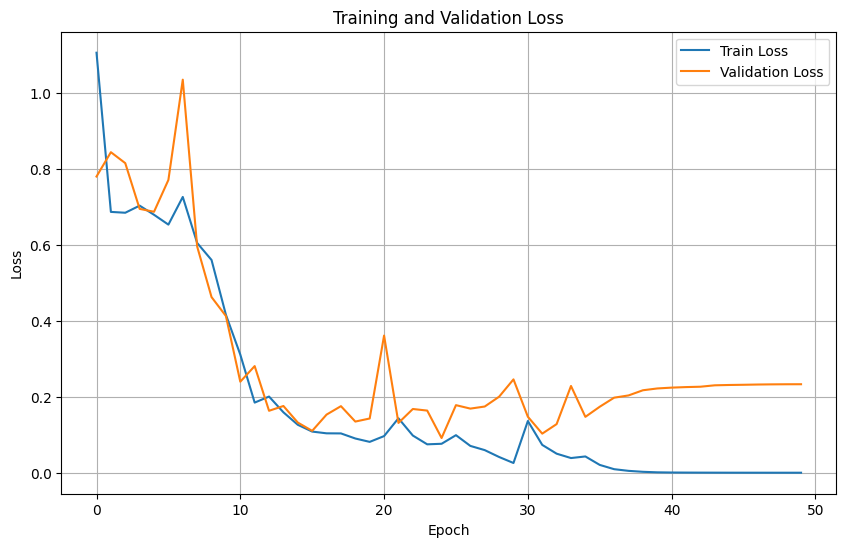

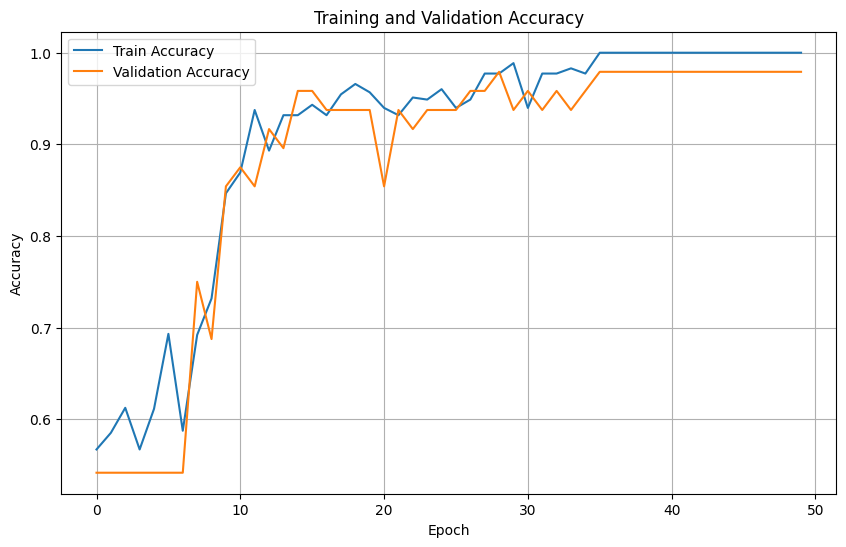

In [18]:
# Parametry
num_epochs = 50
learning_rate = 5e-5
batch_size = 8

# Przygotowanie LabelEncoder dla etykiet
label_encoder = LabelEncoder()
train_labels = train_df['name'].unique()
label_encoder.fit(train_labels)

# Przygotowanie dataloaderów
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Funkcja do obliczania metryk
def compute_metrics(predictions, labels):
    pred_labels = predictions.argmax(dim=-1)
    accuracy = (pred_labels == labels).sum().item() / len(labels)
    return accuracy

# Funkcja do trenowania jednej epoki
def train_one_epoch(model, train_dataloader, optimizer, loss_fn, lr_scheduler, device, label_encoder):
    model.train()
    total_loss = 0
    total_accuracy = 0

    for batch in train_dataloader:
        optimizer.zero_grad()

        # Przesyłanie danych do urządzenia
        images, labels = batch
        images = images.squeeze().to(device)
        labels = label_encoder.transform(labels)
        labels = torch.tensor(labels).to(device)

        # Forward pass
        outputs = model(images)
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        total_loss += loss.item()

        # Obliczanie dokładności
        accuracy = compute_metrics(logits, labels)
        total_accuracy += accuracy

        # Backpropagation
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

    avg_loss = total_loss / len(train_dataloader)
    avg_accuracy = total_accuracy / len(train_dataloader)
    return avg_loss, avg_accuracy

# Funkcja do ewaluacji
def evaluate(model, test_dataloader, loss_fn, device, label_encoder):
    model.eval()
    total_loss = 0
    total_accuracy = 0

    with torch.no_grad():
        for batch in test_dataloader:
            # Przesyłanie danych do urządzenia
            images, labels = batch
            images = images.squeeze().to(device)
            labels = label_encoder.transform(labels)
            labels = torch.tensor(labels).to(device)

            # Forward pass
            outputs = model(images)
            logits = outputs.logits
            loss = loss_fn(logits, labels)
            total_loss += loss.item()

            # Obliczanie dokładności
            accuracy = compute_metrics(logits, labels)
            total_accuracy += accuracy

    avg_loss = total_loss / len(test_dataloader)
    avg_accuracy = total_accuracy / len(test_dataloader)
    return avg_loss, avg_accuracy

# Funkcja do treningu i ewaluacji
def train_and_evaluate(model, train_dataloader, test_dataloader, num_epochs, learning_rate, device):
    # Inicjalizacja optymalizatora i scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    num_training_steps = num_epochs * len(train_dataloader)
    lr_scheduler = get_scheduler(
        "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
    )

    loss_fn = torch.nn.CrossEntropyLoss()
    train_losses, eval_losses = [], []
    train_accuracies, eval_accuracies = [], []

    for epoch in tqdm(range(num_epochs)):
        # Trening
        train_loss, train_accuracy = train_one_epoch(
            model, train_dataloader, optimizer, loss_fn, lr_scheduler, device, label_encoder
        )
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Ewaluacja
        eval_loss, eval_accuracy = evaluate(
            model, test_dataloader, loss_fn, device, label_encoder
        )
        eval_losses.append(eval_loss)
        eval_accuracies.append(eval_accuracy)

        print(
            f"Epoch {epoch + 1}/{num_epochs} - Train loss: {train_loss:.4f}, "
            f"Train accuracy: {train_accuracy:.4f}, Eval loss: {eval_loss:.4f}, "
            f"Eval accuracy: {eval_accuracy:.4f}"
        )

        torch.save(model.state_dict(), r"test.pth")

    return train_losses, eval_losses, train_accuracies, eval_accuracies

# Wykresy wyników
def plot_metrics(train_metrics, eval_metrics, metric_name, title):
    plt.figure(figsize=(10, 6))
    plt.plot(train_metrics, label=f'Train {metric_name}')
    plt.plot(eval_metrics, label=f'Validation {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Wywołanie funkcji treningowej
train_losses, eval_losses, train_accuracies, eval_accuracies = train_and_evaluate(
    model, train_dataloader, test_dataloader, num_epochs, learning_rate, device
)

# Rysowanie wykresów
plot_metrics(train_losses, eval_losses, 'Loss', 'Training and Validation Loss')
plot_metrics(train_accuracies, eval_accuracies, 'Accuracy', 'Training and Validation Accuracy')

In [19]:
torch.save(model.state_dict(), r"test.pth")